**Seasonality**

In [1]:
# load traffic data
import pandas as pd
tunnel = pd.read_csv('../../../data/tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period('D')
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [2]:
tunnel.index.max()

Period('2005-11-16', 'D')

In [3]:
from matplotlib import pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc('figure', autolayout=True, figsize=(11,5))
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold',
       titlesize=16, titlepad=10)
plot_params = dict(
  color=0.75, style='.-', markeredgecolor='0.25', markerfacecolor='0.25',
  legend=False,
)

In [4]:
import seaborn as sns
def seasonal_plot(x, y, period, freq, ax=None):
  if ax is None:
    _, ax = plt.subplots()
  # Create a palette of color for every different period (x serie) in the data 
  palette = sns.color_palette('husl', n_colors=x[period].nunique())
  # create a line plot for every diferent period in the data
  ax = sns.lineplot(x=freq, y=y, hue=period, data=x, ci=False, ax=ax, palette=palette, legend=False)
  ax.set_title(f'Seasonal Plot ({period}/{freq})')
  # create the legend
  for line, name in zip(ax.lines, x[period].unique()):
    y_ = line.get_ydata()[-1]
    ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(),
                xycoords=ax.get_yaxis_transform(), textcoords='offset points',
                size=14, va='center')
  return ax

In [5]:
from scipy.signal import periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
  fs = pd.Timedelta('365D') / pd.Timedelta('1D')
  freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window='boxcar',
                                     scaling='spectrum')
  if ax is None:
    _, ax = plt.subplots()
  ax.step(freqencies, spectrum, color='purple')
  ax.set_xscale('log')
  ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
  ax.set_xticklabels([
    'Anual',
    'Semestral',
    'Trimestral',
    'Bimensual',
    'Mensual',
    'Bisemanal',
    'Semanal',
    'Semisemanal'
  ], rotation=30,)
  ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
  ax.set_ylabel('variance')
  ax.set_title('Periodogram')
  return ax

/var/folders/nf/hsmn691n5xv9xhtsgqfd72vc0000gp/T/ipykernel_46799/3239171619.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(x=freq, y=y, hue=period, data=x, ci=False, ax=ax, palette=palette, legend=False)
/var/folders/nf/hsmn691n5xv9xhtsgqfd72vc0000gp/T/ipykernel_46799/3239171619.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(x=freq, y=y, hue=period, data=x, ci=False, ax=ax, palette=palette, legend=False)


<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='NumVehicles'>

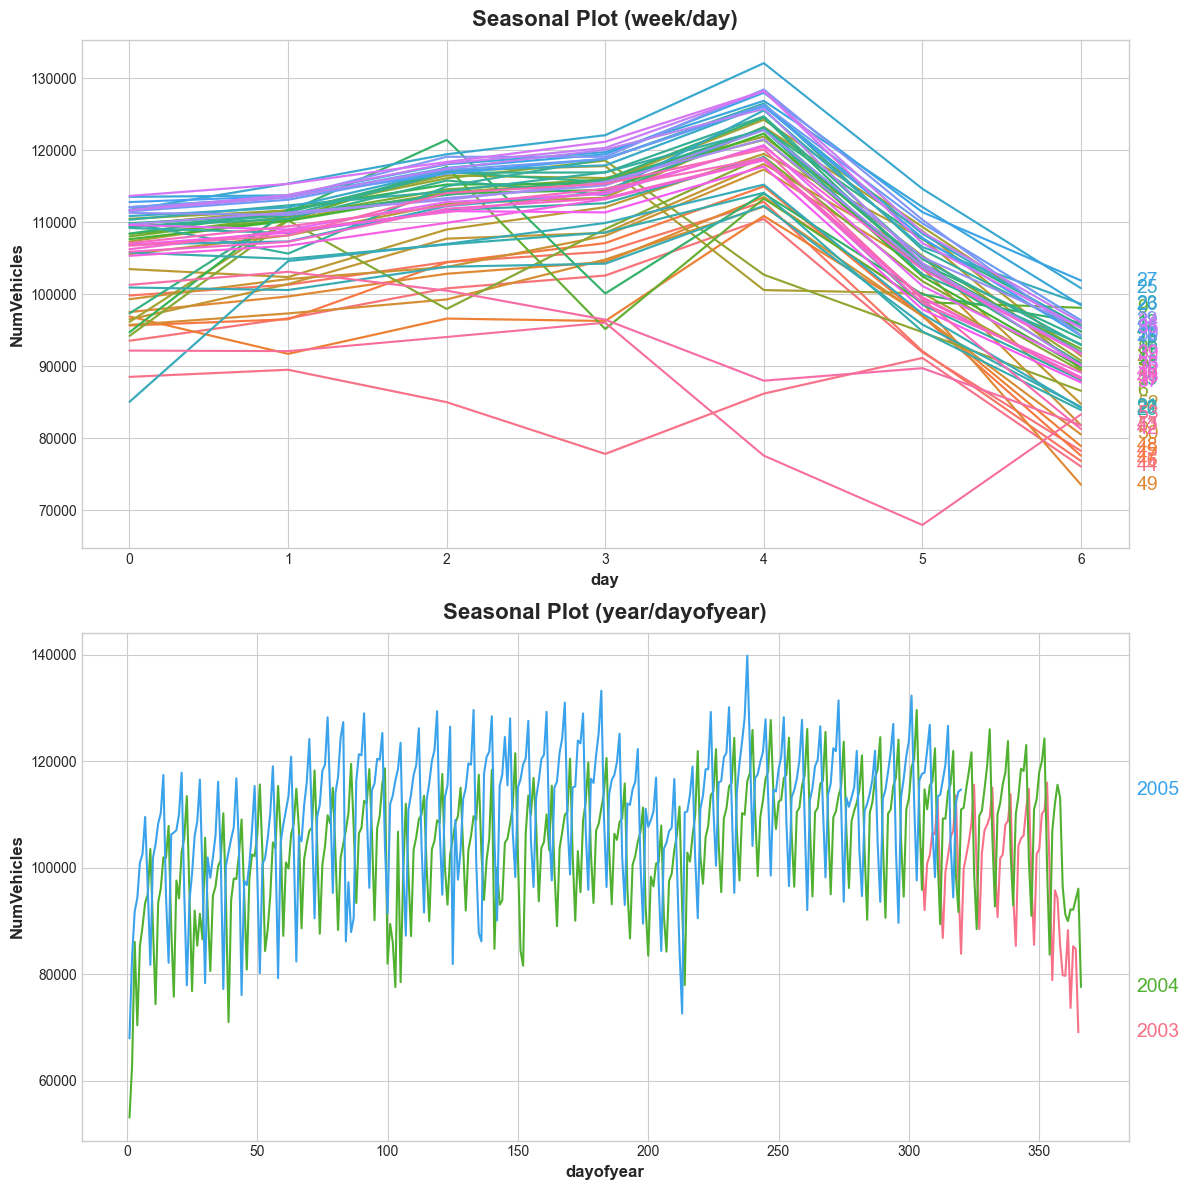

In [6]:
X = tunnel.copy()
X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 12))
# x -> show as many series as weeks in the data
# y -> day of the week
# with this plot we can observe the seasonality by days in diferent weeks
seasonal_plot(X, y='NumVehicles', period='week', freq='day', ax=ax0)
# x -> show as many series as years in the data (2003, 2004, 2005)
# y -> day of the year
# with this plot we can observe the seasonality by days in diferent years
seasonal_plot(X, y='NumVehicles', period='year', freq='dayofyear', ax=ax1)

<Axes: title={'center': 'Periodogram'}, ylabel='variance'>

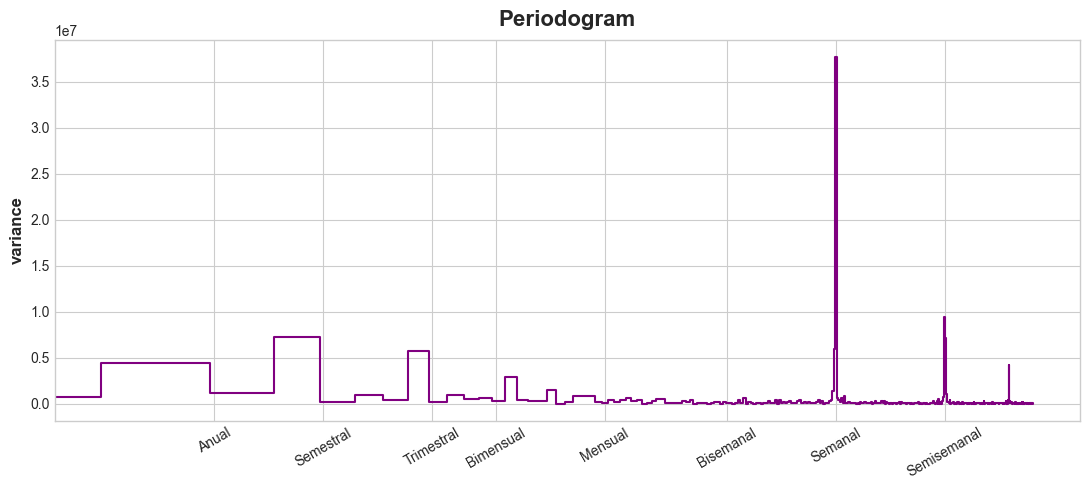

In [7]:

plot_periodogram(tunnel.NumVehicles)

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
fourier = CalendarFourier(freq='A', order=10)
dp = DeterministicProcess(
  index=tunnel.index,
  constant=True,
  order=1,
  seasonal=True,
  additional_terms=[fourier],
  drop=True
)
X = dp.in_sample()

/Users/asaucedo/workspaces/python3/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


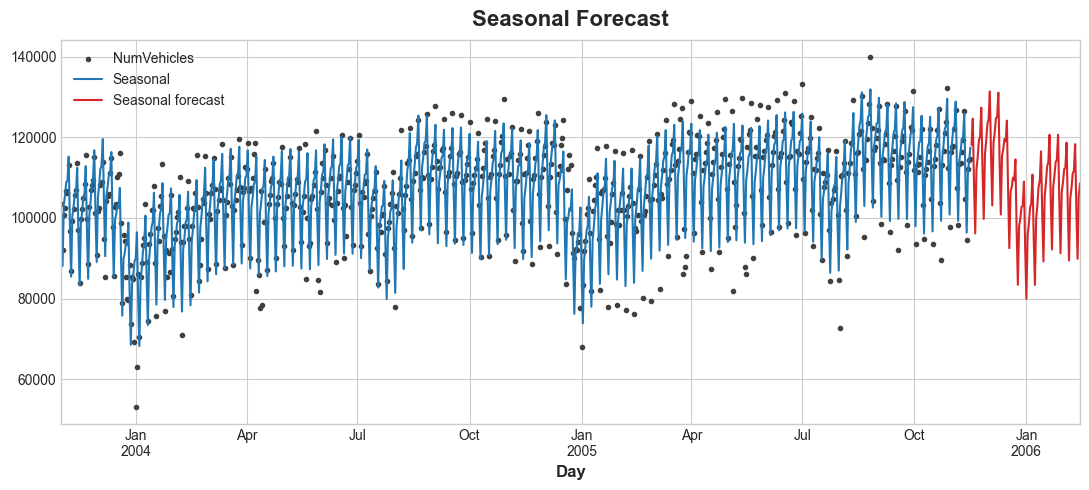

In [9]:
# fit the model and make predictions
from sklearn.linear_model import LinearRegression
y = tunnel.NumVehicles
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title='Seasonal Forecast')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax = y_fore.plot(ax=ax, label='Seasonal forecast', color='C3')
_ = ax.legend()